<a href="https://colab.research.google.com/github/JuanSpecht/ML2021/blob/main/TP5/ML_TP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje de Máquina - TP5: Sommelier de cerveza

## Cargo el dataset

In [1]:
import pandas as pd

reviews1_raw = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBEE/data/beer_reviews_1.csv")
reviews2_raw = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBEE/data/beer_reviews_2.csv")

reviews1 = reviews1_raw.copy()
reviews2 = reviews2_raw.copy()

reviews = pd.concat([reviews1, reviews2])
reviews.reset_index(inplace=True, drop=True)

reviews.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


## Análisis exploratorio y limpieza del dataset

In [2]:
'''
Cambio el nombre de 'beer_beerid' por legibilidad y descarto los atributos 
'review_profilename' (que a priori no parece informativo) y 'review_time' ya que 
no voy a realizar un análisis temporal.
''' 

reviews.rename(columns={'beer_beerid': 'beer_id'}, inplace=True)
reviews = reviews.drop(['review_profilename', 'review_time'], 1)

### Chequeo si hay nulos

In [3]:
print(reviews.isnull().sum())
nans = pd.isnull(reviews).sum().sum()
print('\nHay un %.0f%% de valores nulos en el dataset.' % (100*nans/reviews.shape[0]))

brewery_id               0
brewery_name            15
review_overall           0
review_aroma             0
review_appearance        0
beer_style               0
review_palate            0
review_taste             0
beer_name                0
beer_abv             67785
beer_id                  0
dtype: int64

Hay un 4% de valores nulos en el dataset.


* Hay 67785 reseñas donde está ausente el valor del abv (graduación alcohólica) y algunas pocas donde falta el nombre de la cervecería. En comparación con el tamaño del dataset este número es muy pequeño (4%) así que descarto dichos datos.

In [4]:
reviews = reviews.dropna()

### A continuación resuelvo una discrepancia entre la cantidad de IDs de cervezas únicos y la cantidad de nombres de cervezas

In [5]:
reviews['beer_name'].value_counts()

90 Minute IPA                          3290
Old Rasputin Russian Imperial Stout    3111
Sierra Nevada Celebration Ale          3000
India Pale Ale                         2960
Two Hearted Ale                        2728
                                       ... 
De Horste Brewmaster's Signature          1
Ebenezer's Spiced Ale                     1
Anxa El Rey                               1
Cascade Porter                            1
Raspberry Belgian Tripel                  1
Name: beer_name, Length: 44076, dtype: int64

In [6]:
reviews['beer_id'].value_counts()

2093     3290
412      3111
1904     3000
1093     2728
4083     2704
         ... 
71490       1
28600       1
64818       1
43628       1
69853       1
Name: beer_id, Length: 49001, dtype: int64

* Vemos que hay 44076 nombres únicos de cervezas, mientras que los IDs únicos son 49001, con lo cual hay cervezas con el mismo nombre pero diferente ID. Para ver el motivo de esta discrepancia busco las filas con el mismo valor de `beer_name` pero distinto valor de `beer_id`:

In [7]:
df1 = reviews.drop_duplicates(['beer_name', 'beer_id'], keep='last')
df1 = df1[df1.duplicated(['beer_name'], keep=False)]
df1.head()

,brewery_id,brewery_name,review_overall,review_aroma,review_appearance,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_id
328,1075,Caldera Brewing Company,1.0,1.5,1.0,American Adjunct Lager,1.0,1.0,Lawnmower Lager,3.9,20817
393,1454,Broad Ripple Brew Pub,4.0,3.5,4.0,English Brown Ale,3.5,3.5,Nut Brown,4.7,55097
725,1075,Caldera Brewing Company,4.0,4.0,4.0,American Porter,3.5,4.0,Coconut Porter,9.5,76963
877,850,Moon River Brewing Company,4.0,3.5,3.0,Belgian Pale Ale,4.0,4.0,Inspiration Ale,6.0,2724
913,8802,Conwy Brewery Ltd,3.0,3.0,3.0,English Bitter,3.0,3.0,Celebration Ale,4.2,45855


#### Tomo el caso de la cerveza `Lawnmower Lager`: 

In [8]:
df1 = df1[reviews['beer_name'] == 'Lawnmower Lager']
df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,brewery_id,brewery_name,review_overall,review_aroma,review_appearance,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_id
328,1075,Caldera Brewing Company,1.0,1.5,1.0,American Adjunct Lager,1.0,1.0,Lawnmower Lager,3.9,20817
531391,12471,Ellersick Brewing Company,4.0,4.0,4.0,American Pale Lager,3.5,3.5,Lawnmower Lager,4.8,56095
1017305,12547,The Livery,4.0,3.0,3.5,German Pilsener,4.0,3.5,Lawnmower Lager,4.0,35435


* Se puede ver que la discrepancia entre la cantidad de valores distintos de `beer_name` y de `beer_id` se debe a que existen cervezas con el mismo nombre elaboradas por distintas cervecerías, a las cuales se les asigna un ID distinto. En algunos casos incluso están catalogadas como diferentes tipos de cerveza (según el atributo `beer_style`).
Por lo tanto voy a considerar sólo el atributo `beer_id` para identificar a cada cerveza.

### Algo similar sucede con los atributos `brewery_name` y `brewery_id`:

In [9]:
reviews['brewery_name'].value_counts()

Boston Beer Company (Samuel Adams)    38812
Dogfish Head Brewery                  33800
Stone Brewing Co.                     33022
Sierra Nevada Brewing Co.             28637
Bell's Brewery, Inc.                  24975
                                      ...  
Bir&#371; Alus                           1
Het Brouw Café                            1
Königsegger Walderbräu AG                 1
Brauerei Georg Michael GmbH               1
Castle Eden Brewery Ltd                   1
Name: brewery_name, Length: 5155, dtype: int64

In [10]:
reviews['brewery_id'].value_counts()

35       38812
10099    33800
147      33022
140      28637
287      24975
         ...  
13662        1
6871         1
23648        1
16293        1
2592         1
Name: brewery_id, Length: 5230, dtype: int64

* Al igual que lo que sucedía con las cervezas, hay 5155 nombres únicos de cervecerías, mientras que los IDs únicos son 5230, con lo cual hay cervecerías con el mismo nombre pero diferente ID. Para hallar le motivo de la diferencia repito el procedimiento anterior y observo sólamente las filas con el mismo valor de `brewery_name` pero distinto valor de `brewery_id`:

In [11]:
df2 = reviews.drop_duplicates(['brewery_name', 'brewery_id'], keep='last')
df2 = df2[df2.duplicated(['brewery_name'], keep=False)]
df2.head()

,brewery_id,brewery_name,review_overall,review_aroma,review_appearance,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_id
2768,16994,Ohio Brewing Company,2.5,2.0,3.0,Irish Red Ale,2.5,2.0,Cardinal Ale,5.0,46254
7201,12003,Emmett's Brewing Company,3.5,3.5,4.0,American Amber / Red Ale,3.0,3.5,Centennial Amber Ale,5.2,26854
9996,21590,Ram Restaurant & Brewery,3.5,3.5,3.5,American IPA,3.5,3.0,Big Red IPA,6.0,54411
41807,2414,Tied House Cafe & Brewery,3.0,2.5,3.0,English Brown Ale,3.0,2.5,Ironwood Dark,4.9,6030
42919,13228,Green Man Brewery,3.5,3.5,3.0,English Barleywine,3.5,3.5,Enrico's Cure,14.5,66769


#### Tomo el caso de la cervecería `Emmett's Brewing Company`: 

In [12]:
df2 = df2[reviews['brewery_name'] == 'Emmett\'s Brewing Company']
df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,brewery_id,brewery_name,review_overall,review_aroma,review_appearance,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_id
7201,12003,Emmett's Brewing Company,3.5,3.5,4.0,American Amber / Red Ale,3.0,3.5,Centennial Amber Ale,5.2,26854
256225,5188,Emmett's Brewing Company,3.5,3.5,3.5,American Double / Imperial IPA,3.5,4.0,Imperial Pale Ale,10.0,57483
459529,9704,Emmett's Brewing Company,4.0,3.5,4.0,American Pale Lager,3.5,4.0,Munich Light,4.0,26107


* Vemos que tiene asignados tres IDs distintos. Al buscar en BeerAdvocate los distintos IDs de una misma cervecería se ve que corresponden a distintas sucursales de una misma cadena. Asumiendo que las cervezas que venden las cerveceras en diferentes sucursales son iguales, utilizo sólo el atributo `brewery_name` y descarto `brewery_id`.

In [13]:
reviews = reviews.drop('brewery_id', 1)

### Histograma de los atributos numéricos

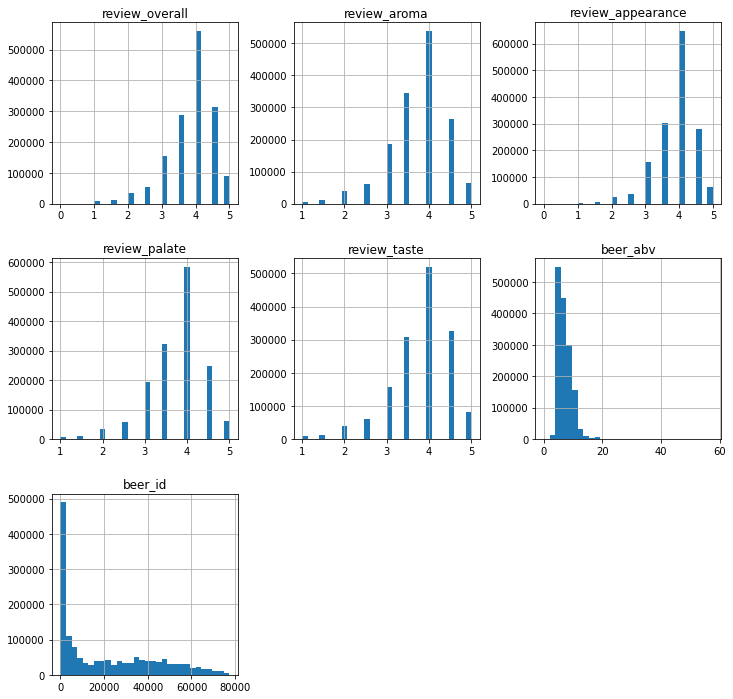

In [14]:
import matplotlib.pyplot as plt

reviews.hist(figsize=(12,12), bins=30)
plt.show()

* Se puede ver que una gran mayoría de las reviews son para cervezas con un ID bajo. Esto puede interpretarse como que hay unas pocas cervezas muy populares, y tienen un ID bajo dado que su popularidad hizo que aparezcan primero reviews para ellas que para otras.
* [Los puntajes de BeerAdvocate están entre 1 y 5](https://www.beeradvocate.com/community/threads/how-to-review-a-beer.241156/), pero en los histogramas de los atributos `review_overall` y `review_appearance` se ve que hay algunas (muy pocas) reviews con valor `0`. Descarto estos datos.



In [15]:
reviews = reviews.drop(reviews[(reviews.review_overall < 1) | (reviews.review_appearance < 1)].index)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518807 entries, 0 to 1586613
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   brewery_name       1518807 non-null  object 
 1   review_overall     1518807 non-null  float64
 2   review_aroma       1518807 non-null  float64
 3   review_appearance  1518807 non-null  float64
 4   beer_style         1518807 non-null  object 
 5   review_palate      1518807 non-null  float64
 6   review_taste       1518807 non-null  float64
 7   beer_name          1518807 non-null  object 
 8   beer_abv           1518807 non-null  float64
 9   beer_id            1518807 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 127.5+ MB


* Veo que hay atributos categóricos no numéricos de la clase `object`, los convierto a la clase `pandas.Categorical`

In [16]:
reviews[reviews.select_dtypes(['object']).columns] = reviews.select_dtypes(['object']).\
                                                         apply(lambda x: x.astype('category'))

## Agrupamiento de los datos: Clustering jerárquico



### Para esto voy a seleccionar las cervezas que tienen al menos 100 reseñas. Esto reduce el número total de cervezas y mejora el tiempo de ejecución

### Para evaluar el modelo voy a usar tres índices apropiados para problemas en los que no se cuenta con las etiquetas de verdad de campo*:

* Índice de silueta
* Índice de Davies-Bouldin
* Índice de Calinski-Harabasz

[*Fuente](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

FloatProgress(value=0.0, bar_style='info', layout=Layout(visibility='hidden', width='max_content'), max=1.0, s…

Tiempo total: 1.0 minutos.


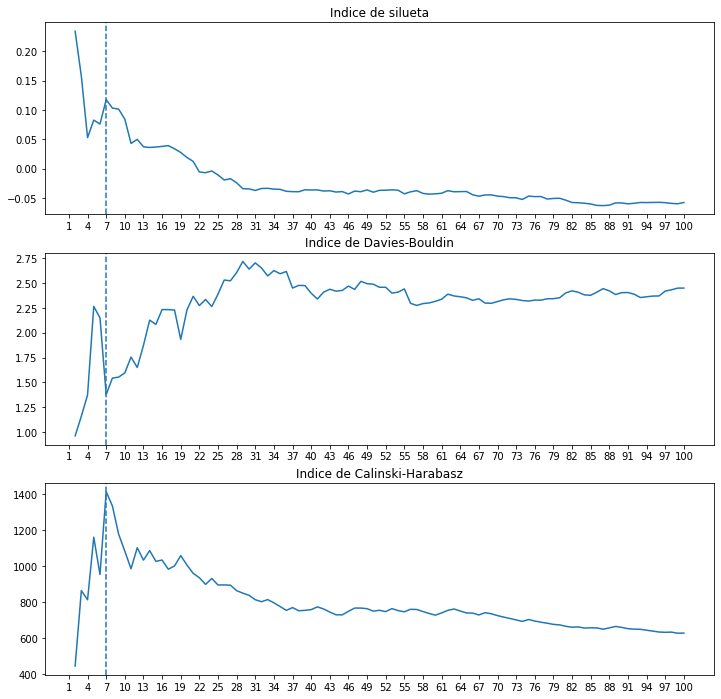

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
import numpy as np
import ipywidgets as widgets
import time

# Genero las variables 'count' y 'mean' para los atributos
reviews_pivot = reviews[['beer_id','review_overall','review_taste','review_aroma','review_palate','review_appearance','beer_abv']]\
    .pivot_table(index='beer_id', aggfunc=('count','mean'))

# Colapso la tabla
reviews_pivot.columns = reviews_pivot.columns.to_series().str.join('_')
reviews_pivot.reset_index(inplace=True)

reviews_pivot.rename(columns={'beer_abv_count': 'count'}, inplace=True)

reviews_pivot.drop(list(reviews_pivot.filter(regex = '_count')), 
                      axis = 1, 
                      inplace = True)

reviews_pivot.sort_values(by=['count'], ascending=False)

# Selecciono las cervezas con 100 o más reseñas
X = reviews_pivot.query('count >= 100').iloc[:, 2:8]

# Hago un barrido entre 2 y 100 clusters
n_clusters_list = np.arange(2, 101, 1)

# Inicializo un diccionario con los labels resultantes de cada entrenamiento
labels_dict = {item: [] for item in n_clusters_list}

# Inicializo un diccionario con los scores resultantes de cada entrenamiento
scores_dict = dict()
scores_dict['silhouette_sc'] = []
scores_dict['davies_bouldin_sc'] = []
scores_dict['calinski_harabasz_sc'] = []

progress_bar = widgets.FloatProgress(
    value=0,
    min=0,
    max=1,
    bar_style='info',
    style={'bar_color': 'green'},
    orientation='horizontal',
    layout=widgets.Layout(width='max_content',
                            visibility = 'hidden')
)
display(progress_bar)
progress_bar.layout.visibility = 'visible'
progress_counter = 0
start_time = time.time()

for n_cls in n_clusters_list:

    # Defino el modelo
    sca = StandardScaler()
    pca = PCA()
    cls = AgglomerativeClustering(n_clusters=n_cls)
    pipe = Pipeline([('sca', sca),
                    ('pca', pca),
                    ('cls', cls)])

    pipe.fit(X)

    labels = cls.labels_

    # Guardo las etiquetas
    labels_dict[n_cls].append(labels)

    # Guardo los índices
    silhouette_sc = silhouette_score(X, labels)
    davies_bouldin_sc = davies_bouldin_score(X, labels)
    calinski_harabasz_sc = calinski_harabasz_score(X, labels)
    scores_dict['silhouette_sc'].append(silhouette_sc)
    scores_dict['davies_bouldin_sc'].append(davies_bouldin_sc)
    scores_dict['calinski_harabasz_sc'].append(calinski_harabasz_sc)

    # Barra de progreso
    progress_counter += 1
    progress_bar.value = progress_counter/len(n_clusters_list)
    progress_bar.description = str(int(100 * progress_counter/len(n_clusters_list))) + ' %'

end_time = time.time()
print('Tiempo total: ' + str('{0:.1f}'.format((end_time - start_time)/60)) + ' minutos.')
progress_bar.layout.visibility = 'hidden'

# Grafico los índices en función de la cantidad de clusters
fig, axs = plt.subplots(nrows=3, figsize=(12,12), sharex=False)
ticks = np.arange(1,101,3).tolist()

axs[0].plot(n_clusters_list,scores_dict['silhouette_sc'])
axs[1].plot(n_clusters_list,scores_dict['davies_bouldin_sc'])
axs[2].plot(n_clusters_list,scores_dict['calinski_harabasz_sc'])

axs[0].set_title('Indice de silueta')
axs[1].set_title('Indice de Davies-Bouldin')
axs[2].set_title('Indice de Calinski-Harabasz')

axs[0].axvline(x=7, linestyle='--')
axs[1].axvline(x=7, linestyle='--')
axs[2].axvline(x=7, linestyle='--')

axs[0].set_xticks(ticks)
axs[1].set_xticks(ticks)
axs[2].set_xticks(ticks)

axs[0].set_xticklabels(ticks)
axs[1].set_xticklabels(ticks)
axs[2].set_xticklabels(ticks)

fig.show()

* El índice de silueta indica lo "bien definido" que están los clústers, y es mejor cuanto más grande es su valor.
* El índice de Calinski-Harabasz indica qué tan similares son los elementos de cada clúster entre sí y es mejor cuanto más grande es su valor.
* El índice de Davies-Bouldin indica el grado de separación entre los clústers, y en ete caso un valor menor indica una mejor separación*
* Se ve que los tres índices coinciden en 7 como el valor óptimo para la cantidad de clústers.

    [*Fuente](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

### Grafico el dendograma con los 7 clústers indicados con diferentes colores

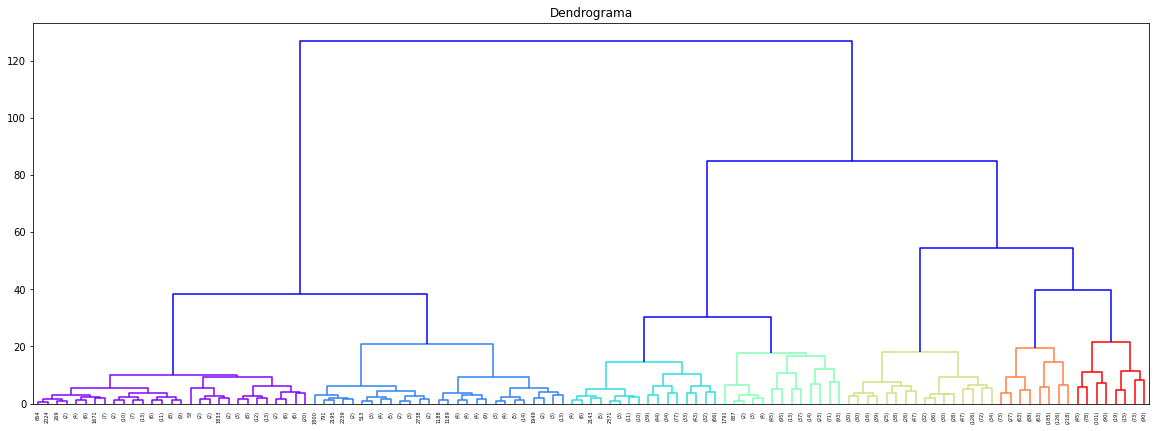

In [18]:
import scipy.cluster.hierarchy as shc
import matplotlib as mpl

# Selecciono las cervezas con 100 o más reseñas
data = reviews_pivot.query('count >= 100').iloc[:, 2:8]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

cmap = plt.cm.rainbow(np.linspace(0, 1, 7))
shc.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])

plt.figure(figsize=(20, 7))  
plt.title("Dendrograma")  
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'), truncate_mode="level", p=6, color_threshold=25)

### Para encontrar la cerveza más representativa de cada clúster (que no necesariamente será la mejor valorada) calculo el promedio de los atributos para todas las cervezas del clúster y luego busco la cerveza más cercana a dicho punto.

#### Obtengo los centroides de cada cluster

In [19]:
X = reviews_pivot.query('count >= 100')
X.insert(loc=0, column='labels', value=labels_dict[7][0])

cluster_centers_df = X.\
                     groupby('labels').\
                     mean().\
                     reset_index()

cluster_centers_df = cluster_centers_df.drop(['beer_id', 'count'], 1)

print('Tabla con los centroides de cada cluster:')
cluster_centers_df

Tabla con los centroides de cada cluster:


,labels,beer_abv_mean,review_appearance_mean,review_aroma_mean,review_overall_mean,review_palate_mean,review_taste_mean
0,0,8.948376,3.850965,3.765379,3.688804,3.735006,3.754296
1,1,5.925492,3.928189,3.819994,3.944637,3.820530,3.891062
2,2,4.768526,2.586958,2.278723,2.670335,2.475465,2.389318
3,3,5.325701,3.631174,3.446423,3.647068,3.501606,3.507001
4,4,10.790945,4.141707,4.160956,4.054116,4.119672,4.210867
5,5,5.204132,3.226399,2.956698,3.178334,3.045394,2.995943
6,6,7.405330,4.121972,4.114621,4.126289,4.061705,4.167793


#### Calculo las distancias de todos los puntos de cada clúster a su centroide y selecciono la menor como la más representativa

In [ ]:
from scipy.spatial.distance import cdist

def closest_point(point, points):
    return points[cdist([point], points).argmin()]

def match_value(df, col1, x, col2):
    return df[df[col1] == x][col2].values[0]

central_beers = pd.DataFrame()

for cluster_tag in range(7):
    df1 = X[X['labels'] == cluster_tag]
    df2 = cluster_centers_df[cluster_centers_df['labels'] == cluster_tag]

    # Genero una columna con las coordenadas de los puntos a comparar
    df1['point'] = [(x1,x2,x3,x4,x5,x6) for x1,x2,x3,x4,x5,x6 in zip(df1['beer_abv_mean'],
                                                    df1['review_appearance_mean'],
                                                    df1['review_aroma_mean'],
                                                    df1['review_overall_mean'],
                                                    df1['review_palate_mean'],
                                                    df1['review_taste_mean'])]
    # Genero una columna con las coordenadas del centroide del clúster
    df2['point'] = [(x1,x2,x3,x4,x5,x6) for x1,x2,x3,x4,x5,x6 in zip(df2['beer_abv_mean'],
                                                    df2['review_appearance_mean'],
                                                    df2['review_aroma_mean'],
                                                    df2['review_overall_mean'],
                                                    df2['review_palate_mean'],
                                                    df2['review_taste_mean'])]

    # Obtengo el punto más cercano al centroide
    df2['closest'] = [closest_point(x, list(df1['point'])) for x in df2['point']]
    df2['beer_id'] = [match_value(df1, 'point', x, 'beer_id') for x in df2['closest']]

    #Armo la tabla con las cervezas más representativas de cada clúster
    beer_name = reviews[reviews['beer_id'] == df2['beer_id'][cluster_tag]]['beer_name'].iloc[0]
    brewery_name = reviews[reviews['beer_id'] == df2['beer_id'][cluster_tag]]['brewery_name'].iloc[0]

    central_beer = reviews_pivot[reviews_pivot['beer_id'] == df2['beer_id'][cluster_tag]]
    central_beer.insert(loc=0, column='cluster_tag', value=cluster_tag)
    central_beer.insert(loc=1, column='beer_name', value=beer_name)
    central_beer.insert(loc=2, column='berewery_name', value=brewery_name)

    central_beers = central_beers.append(central_beer)

In [21]:
print('Estas son las cervezas más representativas de cada clúster:')
central_beers

Estas son las cervezas más representativas de cada clúster:


,cluster_tag,beer_name,berewery_name,beer_id,count,beer_abv_mean,review_appearance_mean,review_aroma_mean,review_overall_mean,review_palate_mean,review_taste_mean
44645,0,Ommegang Aphrodite,Brewery Ommegang,71369,138,8.90,3.884058,3.699275,3.706522,3.710145,3.706522
29818,1,Bitter Woman In The Rye,Tyranena Brewing Company,49861,106,5.90,3.924528,3.797170,3.910377,3.896226,3.863208
1518,2,Miller Genuine Draft,Miller Brewing Co.,2280,607,4.66,2.579077,2.127677,2.662273,2.430807,2.295717
3450,3,Black Toad Dark Ale,Black Toad Brewing Co.,5729,213,5.30,3.647887,3.446009,3.629108,3.462441,3.525822
43694,4,Black Butte XXIII,Deschutes Brewery,70102,233,10.80,4.163090,4.075107,4.156652,4.094421,4.208155
23100,5,Shock Top Belgian White,Anheuser-Busch,39908,585,5.20,3.245299,2.999145,3.250427,3.041880,3.030769
45091,6,Tröegs Perpetual IPA,Tröegs Brewing Company,71969,264,7.50,4.153409,4.128788,4.119318,4.062500,4.138258


## Pregunta 1: ¿Qué factores influyen más en la calidad de una cerveza?

### Según [BeedAdvocate](https://www.beeradvocate.com/community/threads/how-to-review-a-beer.241156/) el atributo `overall` describe la percepción de la calidad general de la cerveza. Para definir los factores que más influyen puedo ver cómo correlaciona cada atributo con el atributo `overall`. 

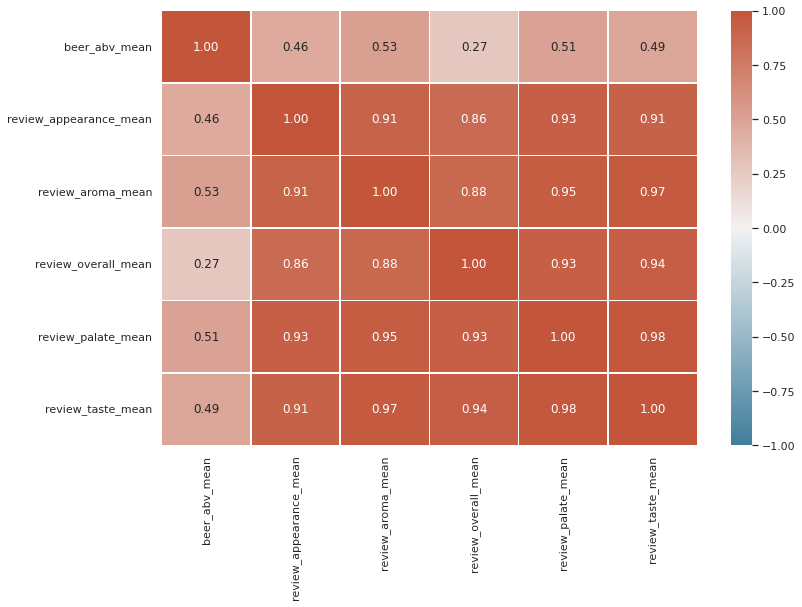

In [22]:
import seaborn as sns

corr = X.iloc[:,3:9].corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set_theme(style="white")

fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=False, linewidths=.5, annot=True, fmt='0.2f')

* Se ve que los atributos que más correlacionan con `overall` son el sabor, con 0.94 y la sensación al paladar, con 0.93

* También se ve que el contenido alcohólico no correlaciona muy bien con ninguno de los demás atributos (como era esperable), pero con `overall` es con el que menos correlaciona. Esto puede indicar una indiferencia generalizada por el contenido alcohólico a la hora de evaluar la calidad de la cerveza

## Pregunta 2: ¿Cómo elegiría N cervezas para recomendar?

### Para esto, primero voy a elegir las cervezas más populares (con el criterio de que tengan más de 500 reseñas) y entre ellas las N mejor valoradas.

In [23]:
# Selecciono 5 cervezas para recomendar
N = 5
top_beers = reviews_pivot.query('count >= 500').sort_values('review_overall_mean', ascending=False).head(N).copy()

beers = []
breweries = []

for beer_id in top_beers['beer_id']:
    beers.append(reviews[reviews['beer_id'] == beer_id]['beer_name'].iloc[0])
    breweries.append(reviews[reviews['beer_id'] == beer_id]['brewery_name'].iloc[0])

top_beers.insert(loc=0, column='beer_name', value=beers)
top_beers.insert(loc=1, column='berewery_name', value=breweries)
print('Las ' + str(N) + ' cervezas recomendadas son:')
top_beers

Las 5 cervezas recomendadas son:


,beer_name,berewery_name,beer_id,count,beer_abv_mean,review_appearance_mean,review_aroma_mean,review_overall_mean,review_palate_mean,review_taste_mean
990,Trappist Westvleteren 12,Brouwerij Westvleteren (Sint-Sixtusabdij van W...,1545,1272,10.2,4.454009,4.583333,4.617925,4.633255,4.718553
12281,Pliny The Younger,Russian River Brewing Company,21690,610,11.0,4.482787,4.723770,4.600000,4.612295,4.724590
28291,Founders CBS Imperial Stout,Founders Brewing Company,47658,637,10.6,4.457614,4.558085,4.591052,4.579278,4.697017
4700,Pliny The Elder,Russian River Brewing Company,7971,2527,8.0,4.388603,4.612188,4.590028,4.451326,4.630985
480,Weihenstephaner Hefeweissbier,Bayerische Staatsbrauerei Weihenstephan,731,1981,5.4,4.380363,4.296315,4.515901,4.283190,4.425038
